In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

import torch

from pathlib import Path
from models.unet import *
from utils.plot import *
from utils.data_loader import *

In [3]:
CT_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\studies\CT-1")
MASK_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\masks")

In [4]:
ds = CTSlices(CT_DIR, MASK_DIR)

In [5]:
model = UNet(n_channels=1, kernel_size=3, ds=1).cuda()

In [6]:
dataloader = DataLoader(
    ds, 
    batch_size=2,                   
    shuffle=False,
    pin_memory=False,
    num_workers=0,
)

In [7]:
N_EPOCHS = 100
learning_rate = 3e-4
WEIGHT_DIR = Path("weights")
if not WEIGHT_DIR.exists():
    WEIGHT_DIR.mkdir(parents=True)

In [8]:
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt,
    max_lr=learning_rate,
    total_steps=N_EPOCHS * len(dataloader),
    cycle_momentum=True,
)

def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return -(numerator + 1) / (denominator + 1)

loss_obj = dice_loss

In [18]:
RESTART_EPOCH = 20
if RESTART_EPOCH != 0:
    WEIGHT_DIR = Path("weights")
    WEIGHT_PATH = WEIGHT_DIR / "weights_epoch_{}.h5".format(RESTART_EPOCH)
    checkpoint = torch.load(WEIGHT_PATH)
    model.load_state_dict(checkpoint['model'])
    opt.load_state_dict(checkpoint['opt'])
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=opt,
        max_lr=learning_rate,
        total_steps=(N_EPOCHS-RESTART_EPOCH) * len(dataloader),
        cycle_momentum=True,
    )

 12%|██████▍                                            | 10/80 [05:50<40:58, 35.12s/it, loss=-0.4912, cur_lr=0.000119]

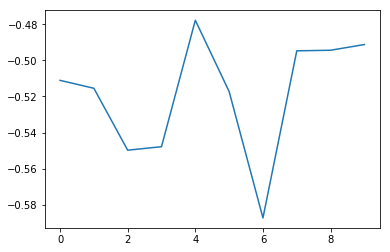

 25%|████████████▊                                      | 20/80 [11:46<35:07, 35.13s/it, loss=-0.5400, cur_lr=0.000281]

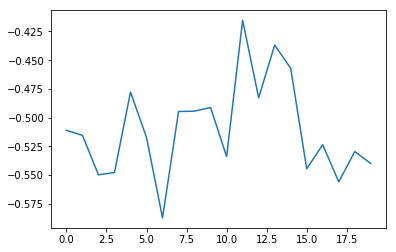

 38%|███████████████████▏                               | 30/80 [17:42<29:17, 35.15s/it, loss=-0.4792, cur_lr=0.000291]

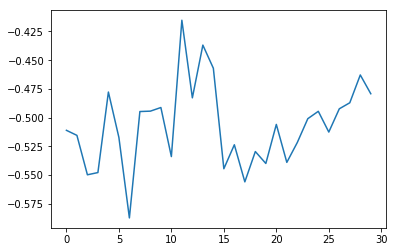

 50%|█████████████████████████▌                         | 40/80 [23:37<23:23, 35.08s/it, loss=-0.5331, cur_lr=0.000243]

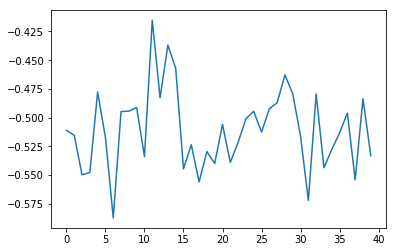

 62%|███████████████████████████████▉                   | 50/80 [29:32<17:30, 35.01s/it, loss=-0.4498, cur_lr=0.000166]

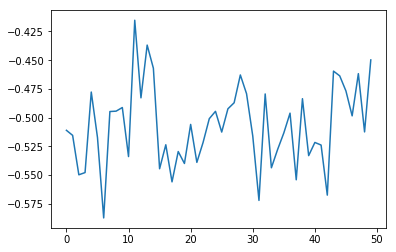

 75%|███████████████████████████████████████             | 60/80 [35:25<11:39, 34.96s/it, loss=-0.5308, cur_lr=8.46e-5]

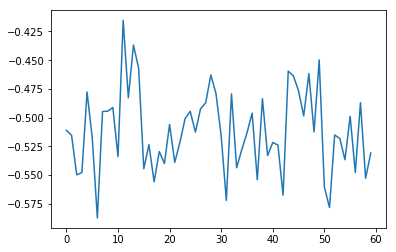

 88%|█████████████████████████████████████████████▌      | 70/80 [41:20<05:51, 35.15s/it, loss=-0.5490, cur_lr=2.28e-5]

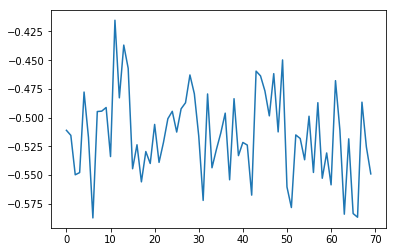

 99%|███████████████████████████████████████████████████▎| 79/80 [46:41<00:35, 35.46s/it, loss=-0.4755, cur_lr=2.17e-7]


In [19]:
losses = []
with tqdm(total=N_EPOCHS-RESTART_EPOCH) as pbar:
    for cur_epoch in range(RESTART_EPOCH+1, N_EPOCHS):
        epoch_loss = 0

        for xs, ys in dataloader:
            opt.zero_grad()
            
            ys_hat = model(xs)
            loss = dice_loss(ys_hat, ys)
            loss.backward()
            opt.step()
            scheduler.step()
            
            epoch_loss += loss.detach().cpu().numpy()
            
        # Progress bar update

        losses.append(epoch_loss / len(dataloader))

        pbar.set_postfix(
            {
                'loss': '{:.4f}'.format(losses[-1]),
                'cur_lr': scheduler.get_last_lr()[0],
            }
        )
        pbar.update(1)

        if cur_epoch % 10 == 0:
            plt.plot(losses)
            plt.show()

            WEIGHT_PATH = WEIGHT_DIR / "weights_epoch_{}.h5".format(cur_epoch)
            torch.save(
                {
                    'model': model.state_dict(),
                    'opt': opt.state_dict(),
                },
                str(WEIGHT_PATH),
            )
            
WEIGHT_PATH = WEIGHT_DIR / "weights_epoch_{}.h5".format(cur_epoch+1)
torch.save(
    {
        'model': model.state_dict(),
        'opt': opt.state_dict(),
    },
    str(WEIGHT_PATH),
)

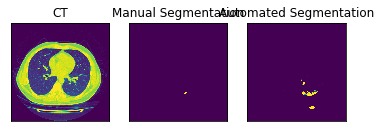

In [25]:
multiplot(
    [
        xs[0,0].detach().cpu().numpy(),
        ys[0,0].detach().cpu().numpy(),
        ys_hat[0,0].detach().cpu().numpy(),
    ],
    [
        "CT",
        "Manual Segmentation",
        "Automated Segmentation",
    ]
)